# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.RandomRotation(8),
                                       transforms.Grayscale(num_output_channels=1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [38]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
torch.Size([128, 1, 28, 28])
torch.Size([128])


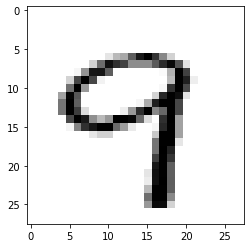

In [39]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
# train_data = train.transform(train_data.numpy())
train_data = [n[0] for n in train]

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train.data))
print(' - max:', torch.max(train.data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

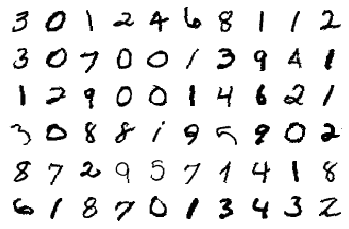

In [40]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
        # Input Block
      self.convblock1 = nn.Sequential(
                          nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),padding=0,bias=False),
                          nn.BatchNorm2d(8),
                          nn.ReLU(),
                          nn.Dropout2d(0.1)
                          
                         ) #26
        
      self.convblock2 = nn.Sequential(
                          nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding=0,bias=False),
                          nn.BatchNorm2d(16),
                          nn.ReLU(),
                          nn.Dropout2d(0.1)

                          ) #24

      self.convblock3 = nn.Sequential(
                          nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=0,bias=False),
                          nn.BatchNorm2d(32),
                          nn.ReLU(),
                          nn.Dropout2d(0.1)
                          
                          ) #22
      
      self.maxpool1 = nn.MaxPool2d(2,2) #11

      self.convblock4 = nn.Sequential(
                          nn.Conv2d(in_channels=32,out_channels=8,kernel_size=(1,1),padding=0,bias=False),
                          nn.BatchNorm2d(8),
                          nn.ReLU(),
                          nn.Dropout2d(0.1)
                          
                          ) #11

      self.convblock5 = nn.Sequential(
                          nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding=0,bias=False),
                          nn.BatchNorm2d(16),
                          nn.ReLU(),
                          nn.Dropout2d(0.1)
                          
                          ) #9

      self.convblock6 = nn.Sequential(
                          nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding=0,bias=False),
                          nn.BatchNorm2d(16),
                          nn.ReLU(),
                          nn.Dropout2d(0.1)
                          
                          )  #9       

      self.convblock7 = nn.Sequential(
                          nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding=0,bias=False),
                          nn.ReLU(),
                          
                          ) #7      


      self.convblock8 = nn.Sequential(
                          nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(7,7),padding=0,bias=False),
                          
                          ) #1                 

    def forward(self, x):
      x = self.convblock1(x)
      x = self.convblock2(x)
      x = self.convblock3(x)
      x = self.maxpool1(x)
      x = self.convblock4(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.convblock7(x)
      x = self.convblock8(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)                          


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [42]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,608
      BatchNorm2d-10           [-1, 32, 22, 22]              64
             ReLU-11           [-1, 32, 22, 22]               0
        Dropout2d-12           [-1, 32, 22, 22]               0
        MaxPool2d-13           [-1, 32, 11, 11]               0
           Conv2d-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [46]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 15
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=6,gamma=0.1)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1146358922123909 Batch_id=468 Accuracy=92.95: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9817/10000 (98.17%)

EPOCH: 1


Loss=0.022768178954720497 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.09082498401403427 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.07305841892957687 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9874/10000 (98.74%)

EPOCH: 4


Loss=0.08480965346097946 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9870/10000 (98.70%)

EPOCH: 5


Loss=0.09835875779390335 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:16<00:00, 27.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.015764111652970314 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.07843955606222153 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.0404784195125103 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.09565816074609756 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.04137801006436348 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.01766788959503174 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.047611579298973083 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.014655237086117268 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.019639143720269203 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:17<00:00, 34.24it/s]



Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)



Text(0.5, 1.0, 'Test Accuracy')

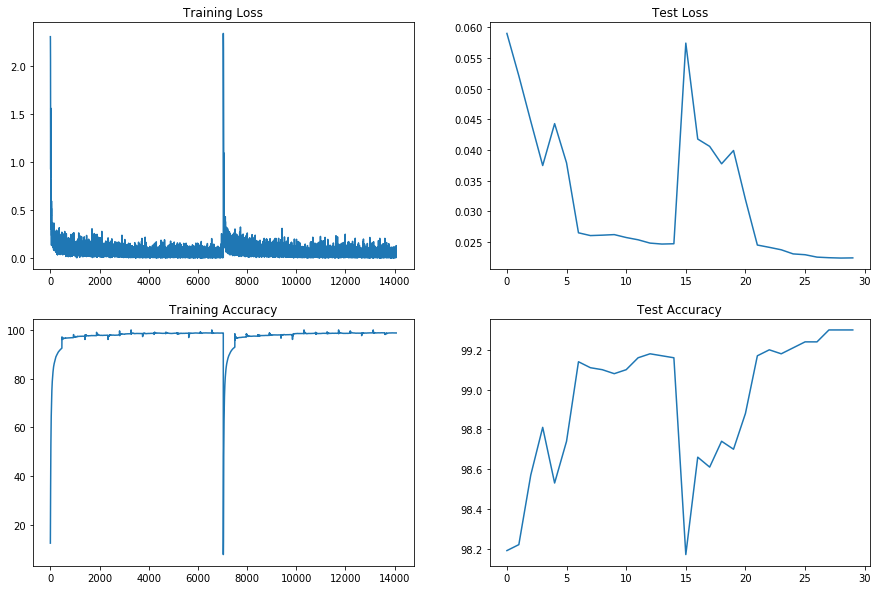

In [47]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")